In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
from numpy.random import normal, uniform
from numba import njit
from tqdm import tqdm
from functools import partial
import jax
from jax import vmap, jit
import jax.numpy as jnp
from jax.config import config
from scipy.stats import qmc
from scipy.stats.qmc import LatinHypercube as LHS
from sklearn.cluster import DBSCAN

def memory(a):
    print("Used {}Mb".format(int(a.size*a.itemsize//1e6)))

# dafult settings
plt.rcParams["figure.figsize"] = [10, 10]
np.set_printoptions(suppress=True, edgeitems=15, precision=3)
jnp.set_printoptions(suppress=True, edgeitems=15, precision=3)
config.update("jax_enable_x64", True)
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["figure.dpi"] = 100 
plt.style.use(['dark_background'])
# plt.style.available

# Teori
Lennard-Jones-potentialen definieras som:
$$ V(r) = 4\varepsilon \left( \left(\sigma / r\right)^{12} - \left(\sigma / r\right)^6 \right)$$
Kraften som partiklarna påverkas av ges av   
$$ F(r_i, r_j) = -\nabla V = 24\varepsilon \sigma^6 \left[  \frac{2\sigma^6}{ {\left| r_i - r_j \right|}^{13} }  - \frac{1}{{\left| r_i - r_j \right|}^{7}} 
\right]
\frac{r_i - r_j}{\left|r_i - r_j\right|}$$
Man kan skriva det här i ett mer numeriskt stabilt sätt om $\sigma=2^{1/6}r$
$$
F(r_i, r_j) = 
\left(\frac{3\varepsilon}{28r^2} \right) \cdot 
\left(\frac{2r}{\left| r_i - r_j \right|} \right)^{14} \cdot 
\left(r_i - r_j\right) - 
\left(\frac{3\varepsilon}{16r^2} \right) \cdot \left(\frac{2r}{\left| r_i - r_j \right|} \right)^8 \cdot
\left(r_i - r_j \right)
$$

# For-loop implementation
Implementation med NumPy + numba och JAX.

In [2]:
np.random.seed(0)

x1, x2, y1, y2 = -100, 100, -100, 100

n_simulations = 100
n_particles = 1000
radius = 0.03 * x2 
eps = 4000
m = 1e4
dt = 1e-6 
frames = 3000
time_factor = 10
time_steps = time_factor * frames
    
# storing stuff
r_evolve = []
T_evolve = np.zeros([n_simulations, frames])
particle_count = np.zeros([n_simulations, frames])

In [3]:
@jit
def distance_matrices(r): 
    r"""
    batched multi target distances: takes (batch_size, n_particles, 2) array
    and computes the distances for a particle with respect to every other particle
    CPU run time is on micro seconds, but need gpu for batch_size > 5.
    Can handle 2000 batches with 1000 particles before memory runs out
    returns (batch_size, n_particles, n_particles) array including the zeros
    """ 
    def distance_matrix(r, ri): 
        r"""
        multi target distances: Computes the distances for a (n_particles, 2) array
        returns (n_particles, n_particles) array with the diagonal elements equal to zero
        """
        def distance_fn(r): 
            r"""
            single target distance: Computes the distance for one particle 
            with respect to every other.
            returns (0, r1, r2, ..., rn) array
            """
            return jnp.linalg.norm(r - ri, axis=-1)

        return vmap(distance_fn)(r)

    return vmap(distance_matrix)(r, r)

@njit
def collision_indices(D, radius):
    cond = (0.0 < D) & (D < 2 * radius) 
    idxb, idx1, idx2 = np.where(cond)
    return idx1, idx2

@njit
def F(s):
    R = np.sqrt(np.sum(s**2, axis=-1))
    R = np.clip(R, a_min=0.01*radius, a_max=2*radius)
    F = ((3*eps/(28*radius**2)) * (2*radius/R)**14 - (3*eps/(16*radius**2)) * (2*radius/R)**8) * s.T 
    F = np.clip(F, a_min=15*x1/dt, a_max=15*x2/dt)
    return F.T

@njit
def wall_collision(r, v):
    x, y = r[...,0], r[...,1]
    vx, vy = v[...,0], v[...,1]

    vx[x > (x2 - radius/2)] = -np.abs(vx[x > (x2 - radius/2)])
    vx[x < (x1 + radius/2)] =  np.abs(vx[x < (x1 + radius/2)])
    vy[y < (y1 + radius/2)] =  np.abs(vy[y < (y1 + radius/2)])
    return vx, vy

@njit
def internal_temperature(v, t):
    v_norm = v / v0
    T = np.mean(v_norm**2)
    return T # + 0.0*t    

@njit
def Langevin_force(v, t):
    T = internal_temperature(v, t) 
    F = np.sqrt(T) * np.random.normal(0, 1, size=v.shape)     
    return 10 * F

In [4]:
for n in range(n_simulations):
    
    r = LHS(2, seed=n).random(n_particles) 
    r = x2 * (2 * r - 1)
    v0 = 100 * x2
    v = v0 * normal(0, 1, size=[n_particles, 2]) # initial velocity
    g = 9.82 * x2 * np.ones([n_particles, 2])
    g[:,0] = 0.0
    
    for t in tqdm(range(time_steps)):

        D = np.asarray(distance_matrices(r[None])) 
        idx1, idx2 = collision_indices(D, radius) 

        if len(idx1):
            s = r[idx1] - r[idx2]
            dv = F(s) * dt
            v[idx1] += dv 
            v[idx1] *= 0.9999  

        # checking for wall collision
        vx, vy = wall_collision(r, v)
        v = np.c_[vx, vy] - m * g * dt + Langevin_force(v, t)
        r += v * dt
        
        particles_inside = r[...,1] < y2
        if len(particles_inside) == 0:
            break
   
        # decreasing the size of the arrys when particles are outside the domain
        if t % time_factor == 0: 
            r = r[particles_inside]
            v = v[particles_inside]
            g = g[particles_inside]
            
#             r_snapshot = r.tolist()
#             r_evolve.append(r_snapshot)
            
            particle_count[n, t//time_factor] = r.shape[0]
            T_evolve[n, t//time_factor] = internal_temperature(v, t)
        
    print(f"simulation {n} finished")
    del r, v, g, D
    
print(f"all {n_simulations} completed")

100%|██████████| 30000/30000 [01:35<00:00, 312.83it/s] 


simulation 0 finished


100%|██████████| 30000/30000 [01:01<00:00, 488.79it/s] 


simulation 1 finished


100%|██████████| 30000/30000 [00:56<00:00, 532.18it/s] 


simulation 2 finished


100%|██████████| 30000/30000 [00:56<00:00, 530.75it/s] 


simulation 3 finished


100%|██████████| 30000/30000 [00:56<00:00, 529.17it/s] 


simulation 4 finished


100%|██████████| 30000/30000 [00:53<00:00, 564.92it/s] 


simulation 5 finished


100%|██████████| 30000/30000 [00:54<00:00, 552.48it/s] 


simulation 6 finished


100%|██████████| 30000/30000 [00:55<00:00, 537.10it/s] 


simulation 7 finished


100%|██████████| 30000/30000 [00:54<00:00, 551.89it/s] 


simulation 8 finished


100%|██████████| 30000/30000 [00:55<00:00, 539.88it/s] 


simulation 9 finished


100%|██████████| 30000/30000 [00:55<00:00, 542.61it/s] 


simulation 10 finished


100%|██████████| 30000/30000 [00:54<00:00, 554.25it/s] 


simulation 11 finished


100%|██████████| 30000/30000 [00:53<00:00, 562.63it/s] 


simulation 12 finished


100%|██████████| 30000/30000 [00:55<00:00, 543.07it/s] 


simulation 13 finished


100%|██████████| 30000/30000 [00:54<00:00, 552.80it/s] 


simulation 14 finished


100%|██████████| 30000/30000 [00:52<00:00, 568.44it/s] 


simulation 15 finished


100%|██████████| 30000/30000 [00:57<00:00, 526.25it/s] 


simulation 16 finished


100%|██████████| 30000/30000 [00:59<00:00, 507.31it/s] 


simulation 17 finished


100%|██████████| 30000/30000 [01:00<00:00, 493.04it/s] 


simulation 18 finished


100%|██████████| 30000/30000 [01:01<00:00, 485.88it/s] 


simulation 19 finished


100%|██████████| 30000/30000 [01:00<00:00, 498.53it/s] 


simulation 20 finished


100%|██████████| 30000/30000 [01:00<00:00, 498.06it/s] 


simulation 21 finished


100%|██████████| 30000/30000 [01:00<00:00, 498.66it/s] 


simulation 22 finished


100%|██████████| 30000/30000 [00:59<00:00, 500.81it/s] 


simulation 23 finished


100%|██████████| 30000/30000 [00:59<00:00, 501.02it/s] 


simulation 24 finished


100%|██████████| 30000/30000 [00:57<00:00, 525.37it/s] 


simulation 25 finished


100%|██████████| 30000/30000 [01:01<00:00, 490.71it/s] 


simulation 26 finished


100%|██████████| 30000/30000 [01:01<00:00, 484.30it/s] 


simulation 27 finished


100%|██████████| 30000/30000 [00:54<00:00, 551.37it/s] 


simulation 28 finished


100%|██████████| 30000/30000 [00:56<00:00, 535.25it/s] 


simulation 29 finished


100%|██████████| 30000/30000 [00:58<00:00, 516.38it/s] 


simulation 30 finished


100%|██████████| 30000/30000 [00:57<00:00, 521.14it/s] 


simulation 31 finished


100%|██████████| 30000/30000 [00:54<00:00, 549.28it/s] 


simulation 32 finished


100%|██████████| 30000/30000 [00:56<00:00, 528.16it/s] 


simulation 33 finished


100%|██████████| 30000/30000 [00:56<00:00, 529.87it/s] 


simulation 34 finished


100%|██████████| 30000/30000 [00:53<00:00, 560.26it/s] 


simulation 35 finished


100%|██████████| 30000/30000 [00:56<00:00, 532.85it/s] 


simulation 36 finished


100%|██████████| 30000/30000 [00:55<00:00, 536.70it/s] 


simulation 37 finished


100%|██████████| 30000/30000 [00:56<00:00, 533.77it/s] 


simulation 38 finished


100%|██████████| 30000/30000 [00:55<00:00, 539.18it/s] 


simulation 39 finished


100%|██████████| 30000/30000 [00:56<00:00, 534.39it/s] 


simulation 40 finished


100%|██████████| 30000/30000 [00:53<00:00, 557.02it/s] 


simulation 41 finished


100%|██████████| 30000/30000 [00:53<00:00, 558.78it/s] 


simulation 42 finished


100%|██████████| 30000/30000 [00:55<00:00, 539.38it/s] 


simulation 43 finished


100%|██████████| 30000/30000 [00:53<00:00, 562.66it/s] 


simulation 44 finished


100%|██████████| 30000/30000 [00:58<00:00, 516.97it/s] 


simulation 45 finished


100%|██████████| 30000/30000 [00:55<00:00, 536.88it/s] 


simulation 46 finished


100%|██████████| 30000/30000 [00:54<00:00, 547.48it/s] 


simulation 47 finished


100%|██████████| 30000/30000 [00:53<00:00, 555.89it/s] 


simulation 48 finished


100%|██████████| 30000/30000 [00:57<00:00, 520.52it/s] 


simulation 49 finished


100%|██████████| 30000/30000 [00:53<00:00, 557.90it/s] 


simulation 50 finished


100%|██████████| 30000/30000 [00:53<00:00, 564.77it/s] 


simulation 51 finished


100%|██████████| 30000/30000 [00:54<00:00, 548.91it/s] 


simulation 52 finished


100%|██████████| 30000/30000 [00:51<00:00, 578.56it/s] 


simulation 53 finished


100%|██████████| 30000/30000 [00:55<00:00, 539.73it/s] 


simulation 54 finished


100%|██████████| 30000/30000 [00:54<00:00, 554.09it/s] 


simulation 55 finished


100%|██████████| 30000/30000 [00:52<00:00, 570.50it/s] 


simulation 56 finished


100%|██████████| 30000/30000 [00:57<00:00, 522.42it/s] 


simulation 57 finished


100%|██████████| 30000/30000 [00:54<00:00, 554.17it/s] 


simulation 58 finished


100%|██████████| 30000/30000 [00:54<00:00, 548.87it/s] 


simulation 59 finished


100%|██████████| 30000/30000 [00:53<00:00, 563.80it/s] 


simulation 60 finished


100%|██████████| 30000/30000 [00:53<00:00, 556.30it/s] 


simulation 61 finished


100%|██████████| 30000/30000 [00:54<00:00, 549.13it/s] 


simulation 62 finished


100%|██████████| 30000/30000 [00:54<00:00, 547.52it/s] 


simulation 63 finished


100%|██████████| 30000/30000 [00:53<00:00, 558.37it/s] 


simulation 64 finished


100%|██████████| 30000/30000 [00:52<00:00, 573.01it/s] 


simulation 65 finished


100%|██████████| 30000/30000 [00:56<00:00, 534.33it/s] 


simulation 66 finished


100%|██████████| 30000/30000 [00:55<00:00, 544.77it/s] 


simulation 67 finished


100%|██████████| 30000/30000 [00:58<00:00, 513.87it/s] 


simulation 68 finished


100%|██████████| 30000/30000 [00:57<00:00, 518.87it/s] 


simulation 69 finished


100%|██████████| 30000/30000 [00:56<00:00, 527.70it/s] 


simulation 70 finished


100%|██████████| 30000/30000 [00:56<00:00, 527.69it/s] 


simulation 71 finished


100%|██████████| 30000/30000 [00:55<00:00, 537.43it/s] 


simulation 72 finished


100%|██████████| 30000/30000 [00:55<00:00, 542.95it/s] 


simulation 73 finished


100%|██████████| 30000/30000 [00:58<00:00, 517.03it/s] 


simulation 74 finished


100%|██████████| 30000/30000 [00:54<00:00, 547.60it/s] 


simulation 75 finished


100%|██████████| 30000/30000 [00:55<00:00, 538.48it/s] 


simulation 76 finished


100%|██████████| 30000/30000 [00:56<00:00, 530.09it/s] 


simulation 77 finished


100%|██████████| 30000/30000 [00:57<00:00, 519.51it/s] 


simulation 78 finished


100%|██████████| 30000/30000 [00:55<00:00, 538.84it/s] 


simulation 79 finished


100%|██████████| 30000/30000 [00:56<00:00, 533.83it/s] 


simulation 80 finished


100%|██████████| 30000/30000 [00:58<00:00, 510.17it/s] 


simulation 81 finished


100%|██████████| 30000/30000 [00:58<00:00, 515.95it/s] 


simulation 82 finished


100%|██████████| 30000/30000 [00:56<00:00, 529.55it/s] 


simulation 83 finished


100%|██████████| 30000/30000 [00:56<00:00, 530.04it/s] 


simulation 84 finished


100%|██████████| 30000/30000 [00:56<00:00, 530.42it/s] 


simulation 85 finished


100%|██████████| 30000/30000 [00:59<00:00, 502.92it/s] 


simulation 86 finished


100%|██████████| 30000/30000 [00:57<00:00, 524.12it/s] 


simulation 87 finished


100%|██████████| 30000/30000 [00:58<00:00, 511.70it/s] 


simulation 88 finished


100%|██████████| 30000/30000 [00:58<00:00, 511.57it/s] 


simulation 89 finished


100%|██████████| 30000/30000 [00:56<00:00, 527.18it/s] 


simulation 90 finished


100%|██████████| 30000/30000 [00:56<00:00, 528.37it/s] 


simulation 91 finished


100%|██████████| 30000/30000 [00:53<00:00, 555.99it/s] 


simulation 92 finished


100%|██████████| 30000/30000 [00:57<00:00, 525.12it/s] 


simulation 93 finished


100%|██████████| 30000/30000 [00:55<00:00, 536.23it/s] 


simulation 94 finished


100%|██████████| 30000/30000 [00:51<00:00, 576.98it/s] 


simulation 95 finished


100%|██████████| 30000/30000 [00:56<00:00, 528.68it/s] 


simulation 96 finished


100%|██████████| 30000/30000 [00:53<00:00, 559.32it/s] 


simulation 97 finished


100%|██████████| 30000/30000 [00:56<00:00, 527.62it/s] 


simulation 98 finished


100%|██████████| 30000/30000 [00:51<00:00, 578.81it/s] 

simulation 99 finished
all 100 completed


(Text(0.5, 0, 'tid'), Text(0, 0.5, 'antal molekyler'))

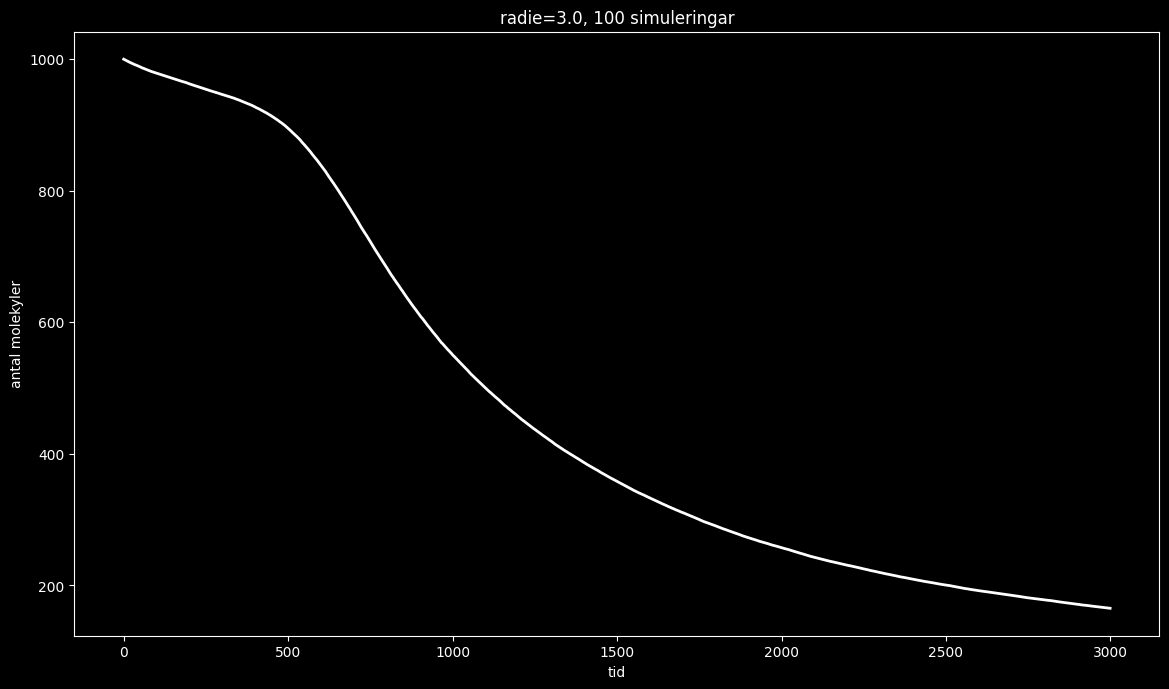

In [6]:
plt.figure(figsize=(14, 8))
plt.title(f"radie={radius}, {n_simulations} simuleringar")
plt.plot(particle_count.mean(0), color="white")
plt.xlabel("tid"), plt.ylabel("antal molekyler")
# plt.savefig("Simulering utan extern värme för 100 simuleringar.png")
# np.save("Antalet partiklar utan extern värme för 100 simuleringar", particle_count)

# Plotting

In [ ]:
class Scene:
    def __init__(self, i=0, 
                 r_evolve=r_evolve, T_evolve=T_evolve,
                 x1=x1, x2=x2, y1=y1, y2=y2,
                 color="red", figsize=(10, 10), dpi=100):     
        
        self.i = i # current frame: default is first frame
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.r_evolve = r_evolve
        self.T_evolve = T_evolve
        self.radius = 225*radius/self.x2

        self.color = color
        self.position = "upper right"
        self.fig, self.ax = plt.subplots(figsize=figsize, dpi=dpi)
        
    def box(self, color="white", axis="off"):
        
        self.ax.plot(2*[self.x1], [self.y1, self.y2], color=color)
        self.ax.plot(2*[self.x2-self.x2/200], [self.y1, self.y2], color=color)
        self.ax.plot([self.x1, self.x2-self.x2/200], 2*[self.y1+self.y2/200], color=color)
        self.ax.axis([self.x1, self.x2, self.y1, self.y2])
        self.ax.axis(axis)
        return self.ax
        
    def particles(self, alpha=0.5): 
        
        x, y = np.asarray(self.r_evolve[self.i]).T
        self.ax.plot(x, y, "o", ms=self.radius, alpha=alpha, color=self.color)
        self.ax.plot([],[], "o", label="N={}".format(particle_count[0][self.i]))
        self.ax.legend(loc=self.position)
        return self.ax
        
    def temperature(self): 
        self.ax.plot([],[], "v", 
                     color=self.color, 
                     label="T={}".format(int(self.T_evolve[0][self.i])))
        self.ax.legend(loc=self.position)
        return self.ax
    
    def __call__(self, i):
        self.i = i
        self.ax.set_title(f"{self.i}:th frame out of {len(self.r_evolve)}")
        self.temperature()
        self.particles()
        self.box()
        return self
    
        
scene = Scene()
scene(-1)

In [ ]:
color = "white"
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

def animate(i):
    ax.clear()
    if i % 20 == 0 and i != 0: 
        print("{:.0f}%".format(100*i/frames))

    # particles
    x, y = np.asarray(r_evolve[i]).T
    ax.plot(x, y, "ro", ms=550*radius/x2/2, alpha=0.5)
    
    # info about the state
    plt.plot([],[],"bv", label="T={:.2f}".format(T_evolve[0][i]))
    plt.plot([],[],"ro", label="N={}".format(particle_count[0][i]))
    plt.plot([],[],"wo", label="t={:.2f}".format(100*i/frames))
    plt.legend(loc="upper right")
    
    # box
    ax.plot(2*[x1], [y1, y2], color=color)
    ax.plot(2*[x2-x2/200], [y1, y2], color=color)
    ax.plot([x1, x2-x2/200], 2*[y1+y2/200], color=color)
    ax.axis([x1, x2, y1, y2])
    ax.axis("off")

writer = FFMpegWriter(fps=30)
ani = FuncAnimation(fig, 
                    animate, 
                    frames=frames)
ani.save('Particle interactions.mp4', writer=writer)